# Clockwork Axion

In [1]:
%run observables.py
%run clockwork_axion.py
%run plot_tools.py
%run util.py
%run analysis_tools.py

## $m_\phi$ vs $mR$ parameterspace from Paper

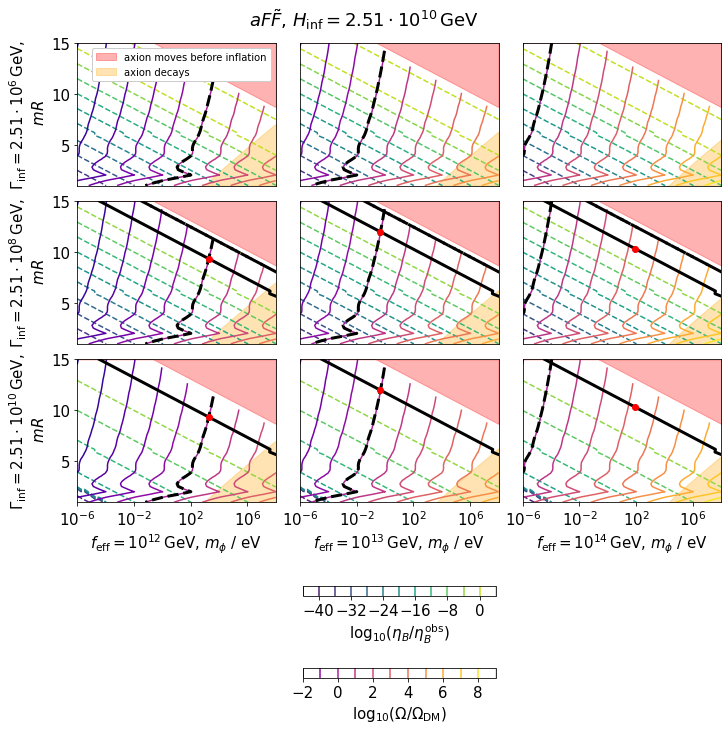

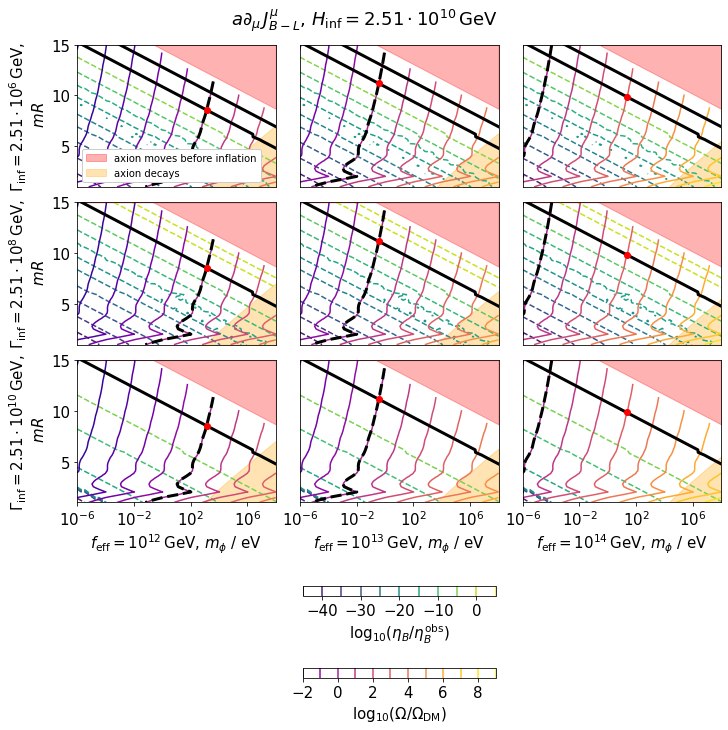

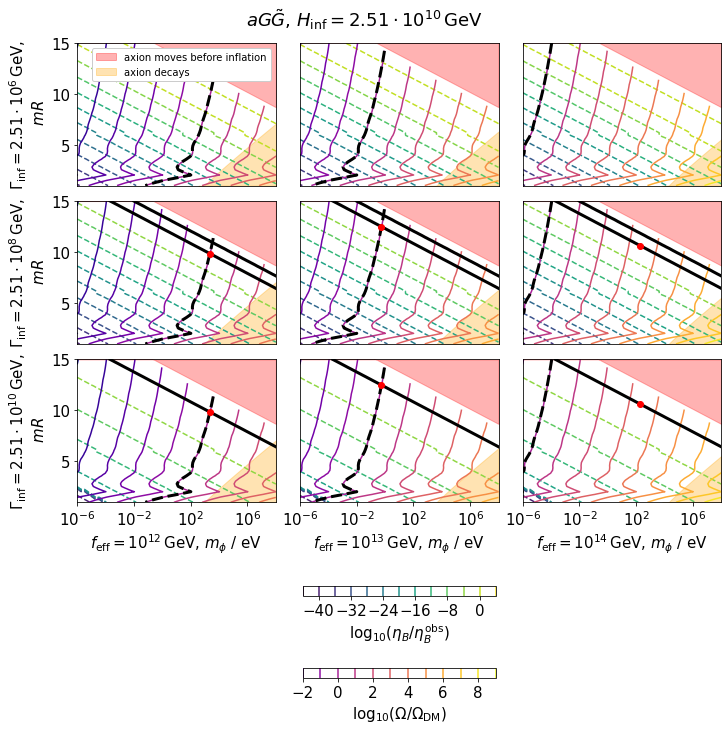

In [28]:
for v in range(1, 3 + 1):
    data = load_data("clockwork_mR_vs_mphi", v)
    m_phi = data["m_phi"]
    mR = data["mR"]
    H_inf = data["H_inf"][0]
    f_effs = [1e12, 1e13, 1e14]
    Gamma_infs = data["Gamma_inf"]
    max_mR = np.array([compute_max_mR(x, H_inf, 3*np.pi/4) for x in m_phi])

    fig, axs = plt.subplots(len(Gamma_infs), len(f_effs), figsize=(10, 10), constrained_layout=True)
    #fig.subplots_adjust(wspace=0, hspace=0)

    def recompute_relic_density(old_Omega_h_sq, new_f_eff):
        eps = calc_eps(mR)
        old_f = calc_f(default_f_eff, eps)
        new_f = calc_f(new_f_eff, eps)
        new_Omega_h_sq = old_Omega_h_sq / old_f[:, None]**2 * new_f[:, None]**2
        return new_Omega_h_sq

    Bs = [[np.log10(recompute_relic_density(data["Omega_h_sq"][0, Gamma_inf_index, ..., 0], f_eff) / Omega_DM_h_sq) 
        for f_eff in f_effs] for Gamma_inf_index in range(len(Gamma_infs))]
    vmin_B = min(np.nanmin(B) for row in Bs for B in row)
    vmax_B = max(np.nanmax(B) for row in Bs for B in row)

    for i, Gamma_inf in enumerate(Gamma_infs):
        A = np.log10(np.abs(data["eta"][0, i, ..., 0]) / eta_B_observed)

        for j, f_eff in enumerate(f_effs):
            min_mR = np.array([compute_min_mR(x, f_eff) for x in m_phi])
            Omega_level = list(find_level(np.log10(m_phi * 1e9), mR, Bs[i][j]))
            eta_level = list(find_level(np.log10(m_phi * 1e9), mR, A))

            axs[i, j].set_xscale("log")

            contour1 = axs[i, j].contour(m_phi * 1e9, mR, A, levels=10, cmap="viridis", linestyles="--")
            contour2 = axs[i, j].contour(m_phi * 1e9, mR, Bs[i][j], levels=10, cmap="plasma", linestyles="-", vmin=vmin_B, vmax=vmax_B)

            for xs, ys in eta_level:
                axs[i, j].plot(10**xs, ys, "k", lw=3)
            for xs, ys in Omega_level:
                axs[i, j].plot(10**xs, ys, "--k", lw=3)

            if len(eta_level) > 0 and len(Omega_level) > 0:
                x, y = find_curve_intersection(*eta_level[0], *Omega_level[0])
                axs[i, j].plot([10**x], [y], "ro")

            axs[i, j].fill_between(m_phi * 1e9, max_mR, mR[-1], alpha=0.3, color="red", label="axion moves before inflation")
            axs[i, j].fill_between(m_phi * 1e9, min_mR, mR[0] , alpha=0.3, color="orange", label="axion decays")
            if (i, j) == (0, 0):
                axs[i, j].legend(framealpha=1, fontsize=10)
            axs[i, j].set_ylim(mR[0], mR[-1])

            if j != 0:
                axs[i, j].set_yticks([], [])
            else:
                axs[i, j].set_ylabel(r"$\Gamma_\mathrm{inf} = " + latex_exponential_notation(Gamma_inf, 2) + r"\, \mathrm{GeV}$" + ",\n $mR$")                   
            if i != len(Gamma_infs) - 1:
                axs[i, j].set_xticks([], [])
            else:
                axs[i, j].set_xlabel(r"$f_\mathrm{eff} = " + latex_exponential_notation(f_eff, 2) + r"\, \mathrm{GeV}$, $m_\phi$ / eV")

    fig.suptitle(f"{transport_equation.source_vector_names[v - 1]}, $H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf, 2)} \\, \\mathrm{{GeV}}$")
    cbar2 = fig.colorbar(contour2, ax=axs, label=r"$\log_{10}(\Omega / \Omega_\mathrm{DM})$", shrink=0.3, location="bottom")
    cbar1 = fig.colorbar(contour1, ax=axs, label=r"$\log_{10}(\eta_B / \eta^\mathrm{obs}_B)$", shrink=0.3, location="bottom") 

    fig.savefig(os.path.join(plotpath, f"cw_m_phi_vs_mR_{v}.pdf"))

## $m_\phi$ vs $\Gamma_\mathrm{inf}$ parameterspace

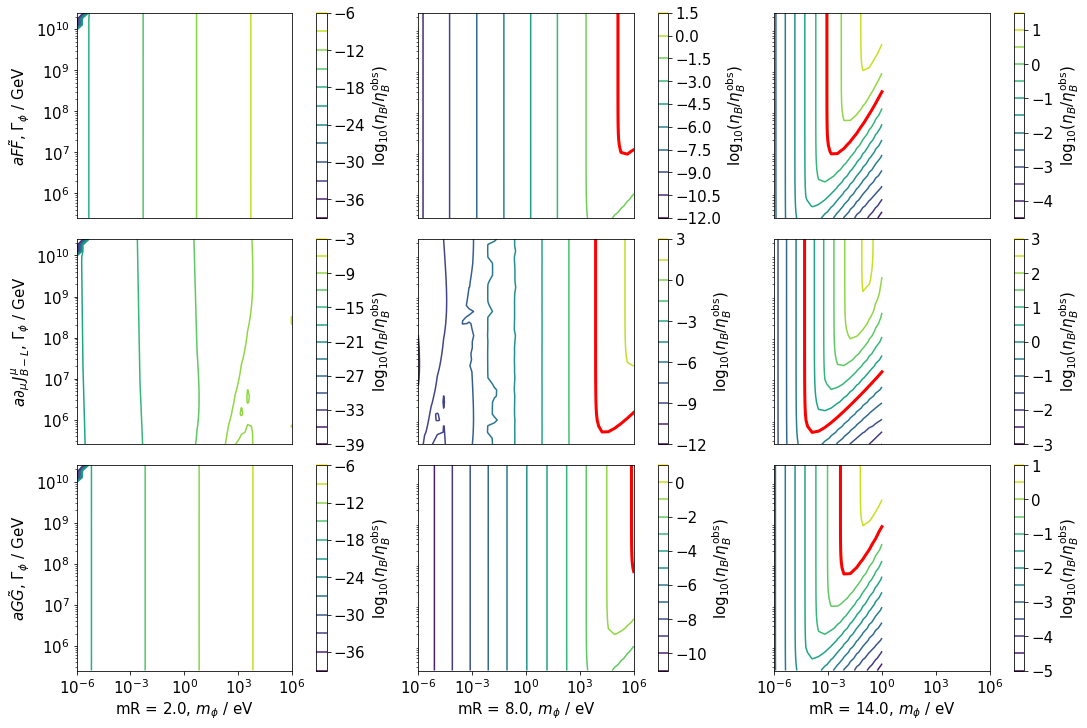

In [25]:
fig, axs = plt.subplots(3, len(mRs), figsize=(15, 10), constrained_layout=True)

for v in range(1, 3 + 1):
    data = load_data("clockwork_Gammainf_vs_mphi", v)
    m_phi = data["m_phi"]
    mRs = data["mR"]
    H_inf = data["H_inf"][0]
    Gamma_infs = data["Gamma_inf"]
    As = [np.log10(np.abs(data["eta"][0, :, i, :, 0]) / eta_B_observed) for i in range(len(mRs))]
    minval = min(np.nanmin(A) for A in As)
    maxval = max(np.nanmax(A) for A in As)

    for i, mR in enumerate(mRs):
        contour1 = axs[v - 1, i].contour(m_phi * 1e9, Gamma_infs, As[i], # vmin=minval, vmax=maxval,
                               levels=10, cmap="viridis", linestyles="-")

        try:
            for xs, ys in find_level(np.log10(m_phi * 1e9), np.log10(Gamma_infs), As[i]):
                axs[v - 1, i].plot(10**xs, 10**ys, "r", lw=3)
        except Exception as e:
            print(e)

        axs[v - 1, i].set_xscale("log")
        axs[v - 1, i].set_yscale("log")
        if i == 0:
            axs[v - 1, i].set_ylabel(transport_equation.source_vector_names[v - 1] + ", $\Gamma_\phi$ / GeV")
        else:
            axs[v - 1, i].set_yticks([], [])
        if v == 3:
            axs[v - 1, i].set_xlabel(f"mR = {mR}, $m_\\phi$ / eV")
        else:
            axs[v - 1, i].set_xticks([], [])

        fig.colorbar(contour1, ax=axs[v - 1, i], label=r"$\log_{10}(\eta_B / \eta^\mathrm{obs}_B)$")
    #plt.title(f"$H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf, 2)} \\, \\mathrm{{GeV}}, \\, mR = {mR}$")
fig.savefig(os.path.join(plotpath, "cw_m_phi_vs_Gamma_inf.pdf"))

## Plot of the effective Potential

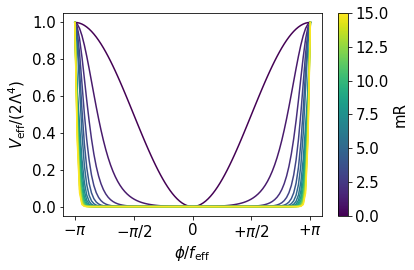

In [26]:
mRs = np.arange(0, 15 + 1, 1) 
cmap = plt.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=np.min(mRs), vmax=np.max(mRs))
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

plt.figure()
for mR in mRs:
    eps = calc_eps(mR)
    alpha_range = np.linspace(-np.pi, np.pi, 100)
    f = 1 # dummy values
    m_phi = 1 # [GeV] # dummy value
    M = m_phi / eps 
    phi_over_f_range = calc_f_eff(f, eps) * alpha_range / f # not a linear map
    Lambda = np.sqrt(M * f)
    y = calc_V_eff_over_f_sq(phi_over_f_range, eps, M) * f**2 / (2*Lambda**4)
    y[0] = 1; y[-1] = 1 # okay this is bad
    c = mappable.to_rgba(mR)
    plt.plot(alpha_range, y, color=c)
    
plt.xlabel(r"$\phi / f_\mathrm{eff}$")
plt.ylabel(r"$V_\mathrm{eff} / (2 \Lambda^4)$")
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\pi/2$", "0", r"$+\pi/2$", r"$+\pi$",])
plt.colorbar(mappable=mappable, label="mR")
plt.tight_layout()
plt.savefig(os.path.join(plotpath, "cw_potential.pdf"))

## Plot of Field Evolution

In [6]:
H_inf = 2e12
Gamma_inf = 1e8
mR = 6
m_phi = 100 * 1e-9 # [GeV]

eps = calc_eps(mR)
M = m_phi / eps 
phi0_over_f = theta_to_phi_over_f(1.0, eps)
tmax_ax = 1 / (eps / 3) * 1e2
tmax_inf = tmax_ax / M * Gamma_inf
_, T_and_H_fn, _ = decay_process.solve(tmax_inf, 0.0, 3*H_inf**2*decay_process.M_pl**2, M, Gamma_inf)
sol = clockwork_axion_field.solve((phi0_over_f, 0.0), (eps, M), tmax_ax, T_and_H_fn, Gamma_inf)
i = np.where(sol.y[0] < 0)[0][0]

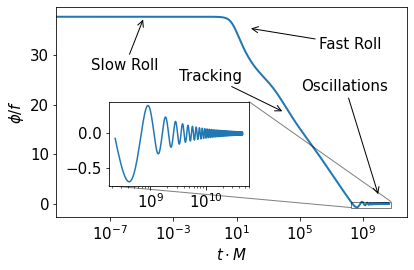

In [13]:
plt.figure()
plt.semilogx(sol.t, sol.y[0, :], lw=2)
plt.xlabel(r"$t \cdot M$")
plt.ylabel(r"$\phi / f$ ")

def annotate(text, arrowxy, textxy):
    plt.annotate(text, xy=arrowxy, xytext=textxy, 
        arrowprops=dict(arrowstyle="->"), xycoords="axes fraction", textcoords="axes fraction")
    
annotate("Slow Roll", (0.25, 1 - 0.05), (0.1, 0.7))
annotate("Fast Roll", (0.55, 1 - 0.1), (0.75, 1 - 0.2))
annotate("Tracking", (0.65, 0.5), (0.35, 0.65))
annotate("Oscillations", (1 - 0.08, 0.1), (0.7, 0.6))

ax = plt.gca()
inset_ax = ax.inset_axes([0.15, 0.15, 0.4, 0.4])
inset_ax.semilogx(sol.t[i:], sol.y[0, i:])
ax.indicate_inset_zoom(inset_ax, edgecolor="black")

plt.tight_layout()
plt.savefig(os.path.join(plotpath, "cw_field_evolution.pdf"))